In [ ]:
!pip install sastrawi
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 69.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.3-py3-none-any.whl size=25316960 sha256=053d8db631aa4b4107e5f91f9e6e0bed6d206f1426b52145b713b61b53612ed6
  Stored in directory: /root/.cache/pip/wheels/fc/76/11/5b953090eebf531f660948a30cd26e70260619f6480f186a5a
  Created wheel for keras_bert: filename=

In [ ]:
from google.colab import drive
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import ktrain
import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/satria_data/dataset_unlabeled_excel.xlsx'


Mounted at /content/drive


In [ ]:
df_pred = pd.read_excel(file_path)
df_pred

,IDText,Text
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...
...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan..."
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...


In [ ]:
df_pred.isna().sum()

IDText    0
Text      0
dtype: int64

In [ ]:
def clean_tweet(tweet):
    tweet = re.sub(r'@\S+', '', tweet).strip()
    tweet = re.sub(r'(https\S+)', '', tweet).strip()
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet).strip()
    tweet = re.sub(r'\[RE.*?\]', '', tweet).strip()
    tweet = re.sub(r'^RT\b\s*', '', tweet).strip()
    tweet = re.sub(r'[^\w\s]', '', tweet).strip()
    return tweet

In [ ]:
df_pred['cleaned'] = df_pred['Text'].apply(clean_tweet)
df_pred

,IDText,Text,cleaned
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,Lu mau org2 prodemokrasi di negara ini bisa pu...
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,Prabowo ditanya soal hutang luar negeri dia me...
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo Ganjar Pranowo itulah beliau soso...
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,Prabowo Gibran yang bisa melakukan itu semua d...
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,Lah justru yg gak nyambung junjungan elu aomkm...
...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...",Bikin bangga deh GanjarMahfud mau alokasikan s...
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,Pak Jokowi sebelum pilpres 2024 berbesar hati ...
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,Sbaiknya si gemot nga usah ikutan debat dehnga...
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk atau bermusyawarah jadi gay...


In [ ]:
df_pred['lowered'] = df_pred['cleaned'].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))
df_pred['tokenized'] = df_pred['lowered'].apply(lambda x: word_tokenize(x))
df_pred

,IDText,Text,cleaned,lowered,tokenized
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,Lu mau org2 prodemokrasi di negara ini bisa pu...,lu mau org2 prodemokrasi di negara ini bisa pu...,"[lu, mau, org2, prodemokrasi, di, negara, ini,..."
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya soal hutang luar negeri dia me...,"[prabowo, ditanya, soal, hutang, luar, negeri,..."
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo ganjar pranowo itulah beliau soso...,"[kiki_daliyo, ganjar, pranowo, itulah, beliau,..."
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,Prabowo Gibran yang bisa melakukan itu semua d...,prabowo gibran yang bisa melakukan itu semua d...,"[prabowo, gibran, yang, bisa, melakukan, itu, ..."
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,Lah justru yg gak nyambung junjungan elu aomkm...,lah justru yg gak nyambung junjungan elu aomkm...,"[lah, justru, yg, gak, nyambung, junjungan, el..."
...,...,...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...",Bikin bangga deh GanjarMahfud mau alokasikan s...,bikin bangga deh ganjarmahfud mau alokasikan s...,"[bikin, bangga, deh, ganjarmahfud, mau, alokas..."
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,pak jokowi sebelum pilpres 2024 berbesar hati ...,"[pak, jokowi, sebelum, pilpres, 2024, berbesar..."
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,Sbaiknya si gemot nga usah ikutan debat dehnga...,sbaiknya si gemot nga usah ikutan debat dehnga...,"[sbaiknya, si, gemot, nga, usah, ikutan, debat..."
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk atau bermusyawarah jadi gay...,"[kebiasaan, merembuk, atau, bermusyawarah, jad..."


In [ ]:
factory = StopWordRemoverFactory()
sastrawi_stopwords = factory.get_stop_words()
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = {'gak', 'yg', 'bgt', 'dr', 'tdk', 'aja', 'dgn', 'yg', 'dpt', 'dlu',
    'emg', 'kok', 'skrg', 'lg', 'smp', 'td', 'tdr', 'tp', 'udh',
    'y', 'cm', 'btw', 'lgsg', 'nih', 'd', 'kt', 'bkn', 'bbrp', 'jg',
    'tpi', 'n', 'ga', 'sm', 'utk', 'ama', 'gmna', 'pdhl', 'bgtu',
    'jd', 'tau', 'dah', 'dri', 'skali', 'gt', 'kpn', 'sdh', 'smua',
    'brp', 'pd', 'nanti', 'trus', 'bgt', 'trnyata', 'klo', 'dg', 'hny',
    'lgsg', 'krg', 'pnya', 'bs', 'jln', 'dgn', 'dik', 'krn', 'mgkn',
    'tdi', 'spt', 'gmn', 'sih', 'dlm', 'kalo', 'jadi', 'utk', 'aj', 'krn',
    'nya', 'kalau', 'spy', 'loh', 'yah', 'sy', 'ksh', 'tuh','lah','si'}
combined_stopwords = set(nltk_stopwords).union(custom_stopwords,sastrawi_stopwords)


df_pred['w/o stopwords'] = df_pred['tokenized'].apply(lambda tokens: [token for token in tokens if token not in combined_stopwords])
df_pred

,IDText,Text,cleaned,lowered,tokenized,w/o stopwords
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,Lu mau org2 prodemokrasi di negara ini bisa pu...,lu mau org2 prodemokrasi di negara ini bisa pu...,"[lu, mau, org2, prodemokrasi, di, negara, ini,...","[lu, mau, org2, prodemokrasi, negara, punya, k..."
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya soal hutang luar negeri dia me...,"[prabowo, ditanya, soal, hutang, luar, negeri,...","[prabowo, ditanya, soal, hutang, luar, negeri,..."
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo ganjar pranowo itulah beliau soso...,"[kiki_daliyo, ganjar, pranowo, itulah, beliau,...","[kiki_daliyo, ganjar, pranowo, beliau, sosok, ..."
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,Prabowo Gibran yang bisa melakukan itu semua d...,prabowo gibran yang bisa melakukan itu semua d...,"[prabowo, gibran, yang, bisa, melakukan, itu, ...","[prabowo, gibran, melakukan, semua, kesejahter..."
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,Lah justru yg gak nyambung junjungan elu aomkm...,lah justru yg gak nyambung junjungan elu aomkm...,"[lah, justru, yg, gak, nyambung, junjungan, el...","[justru, nyambung, junjungan, elu, aomkmkmkmk,..."
...,...,...,...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...",Bikin bangga deh GanjarMahfud mau alokasikan s...,bikin bangga deh ganjarmahfud mau alokasikan s...,"[bikin, bangga, deh, ganjarmahfud, mau, alokas...","[bikin, bangga, deh, ganjarmahfud, mau, alokas..."
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,pak jokowi sebelum pilpres 2024 berbesar hati ...,"[pak, jokowi, sebelum, pilpres, 2024, berbesar...","[pak, jokowi, pilpres, 2024, berbesar, hati, m..."
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,Sbaiknya si gemot nga usah ikutan debat dehnga...,sbaiknya si gemot nga usah ikutan debat dehnga...,"[sbaiknya, si, gemot, nga, usah, ikutan, debat...","[sbaiknya, gemot, nga, usah, ikutan, debat, de..."
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk atau bermusyawarah jadi gay...,"[kebiasaan, merembuk, atau, bermusyawarah, jad...","[kebiasaan, merembuk, bermusyawarah, gaya, kep..."


In [ ]:
df_pred1 = df_pred[['IDText','w/o stopwords']]
factory = StemmerFactory()
stemmer = factory.create_stemmer()
df_pred1['stemmed_tokens'] = df_pred1['w/o stopwords'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
df_pred1

<ipython-input-11-33c7671a99af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred1['stemmed_tokens'] = df_pred1['w/o stopwords'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])


,IDText,w/o stopwords,stemmed_tokens
0,TXT0001,"[lu, mau, org2, prodemokrasi, negara, punya, k...","[lu, mau, org2, prodemokrasi, negara, punya, s..."
1,TXT0002,"[prabowo, ditanya, soal, hutang, luar, negeri,...","[prabowo, tanya, soal, hutang, luar, negeri, j..."
2,TXT0003,"[kiki_daliyo, ganjar, pranowo, beliau, sosok, ...","[kiki daliyo, ganjar, pranowo, beliau, sosok, ..."
3,TXT0004,"[prabowo, gibran, melakukan, semua, kesejahter...","[prabowo, gibran, laku, semua, sejahtera, rakyat]"
4,TXT0005,"[justru, nyambung, junjungan, elu, aomkmkmkmk,...","[justru, nyambung, junjung, elu, aomkmkmkmk, n..."
...,...,...,...
995,TXT0996,"[bikin, bangga, deh, ganjarmahfud, mau, alokas...","[bikin, bangga, deh, ganjarmahfud, mau, alokas..."
996,TXT0997,"[pak, jokowi, pilpres, 2024, berbesar, hati, m...","[pak, jokowi, pilpres, 2024, besar, hati, rang..."
997,TXT0998,"[sbaiknya, gemot, nga, usah, ikutan, debat, de...","[sbaiknya, got, nga, usah, ikut, debat, dehnga..."
998,TXT0999,"[kebiasaan, merembuk, bermusyawarah, gaya, kep...","[biasa, rembuk, musyawarah, gaya, pimpin, ganj..."


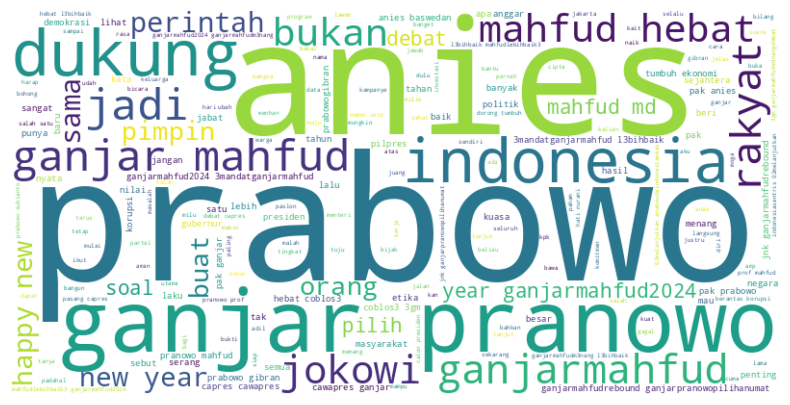

In [ ]:
text_for_wordcloud = ' '.join([' '.join(tokens) for tokens in df_pred1['stemmed_tokens']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
df_pred1['text'] = df_pred1['stemmed_tokens'].apply(lambda x : ' '.join(x))
df_pred_final = df_pred1[['IDText','text']]
df_pred_final

<ipython-input-13-86003a32406c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred1['text'] = df_pred1['stemmed_tokens'].apply(lambda x : ' '.join(x))


,IDText,text
0,TXT0001,lu mau org2 prodemokrasi negara punya sempat b...
1,TXT0002,prabowo tanya soal hutang luar negeri jawab hu...
2,TXT0003,kiki daliyo ganjar pranowo beliau sosok mengag...
3,TXT0004,prabowo gibran laku semua sejahtera rakyat
4,TXT0005,justru nyambung junjung elu aomkmkmkmk ngomong...
...,...,...
995,TXT0996,bikin bangga deh ganjarmahfud mau alokasi teng...
996,TXT0997,pak jokowi pilpres 2024 besar hati rangkul pak...
997,TXT0998,sbaiknya got nga usah ikut debat dehnga jelas ...
998,TXT0999,biasa rembuk musyawarah gaya pimpin ganjar sej...


In [ ]:
df_pred_final.to_csv('/content/drive/My Drive/satria_data/cleaned_pred.csv')

In [ ]:
df_pred_final = pd.read_csv('/content/drive/My Drive/satria_data/cleaned_pred.csv')

In [ ]:
rf_loaded = joblib.load('/content/drive/My Drive/satria_data/random_forest_model.pkl')
svm_loaded = joblib.load('/content/drive/My Drive/satria_data/svm_model.pkl')
vectorizer = joblib.load('/content/drive/My Drive/satria_data/tfidf_vectorizer.pkl')

predictor = ktrain.load_predictor('/content/drive/My Drive/satria_data/Bert_Model_Text_Classification')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
X_pred = vectorizer.transform(df_pred_final['text'])

df_pred_final['randomforest'] = rf_loaded.predict(X_pred)

df_pred_final['svm'] = svm_loaded.predict(X_pred)

df_pred_final['bert'] = predictor.predict(df_pred_final['text'].tolist())

df_pred_final

,Unnamed: 0,IDText,text,randomforest,svm,bert
0,0,TXT0001,lu mau org2 prodemokrasi negara punya sempat b...,1,1,1
1,1,TXT0002,prabowo tanya soal hutang luar negeri jawab hu...,1,1,5
2,2,TXT0003,kiki daliyo ganjar pranowo beliau sosok mengag...,4,4,4
3,3,TXT0004,prabowo gibran laku semua sejahtera rakyat,1,1,1
4,4,TXT0005,justru nyambung junjung elu aomkmkmkmk ngomong...,1,1,1
...,...,...,...,...,...,...
995,995,TXT0996,bikin bangga deh ganjarmahfud mau alokasi teng...,1,1,1
996,996,TXT0997,pak jokowi pilpres 2024 besar hati rangkul pak...,1,1,1
997,997,TXT0998,sbaiknya got nga usah ikut debat dehnga jelas ...,1,1,1
998,998,TXT0999,biasa rembuk musyawarah gaya pimpin ganjar sej...,5,5,1


In [ ]:
df_pred_final.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_pred_final

,IDText,text,randomforest,svm,bert
0,TXT0001,lu mau org2 prodemokrasi negara punya sempat b...,1,1,1
1,TXT0002,prabowo tanya soal hutang luar negeri jawab hu...,1,1,5
2,TXT0003,kiki daliyo ganjar pranowo beliau sosok mengag...,4,4,4
3,TXT0004,prabowo gibran laku semua sejahtera rakyat,1,1,1
4,TXT0005,justru nyambung junjung elu aomkmkmkmk ngomong...,1,1,1
...,...,...,...,...,...
995,TXT0996,bikin bangga deh ganjarmahfud mau alokasi teng...,1,1,1
996,TXT0997,pak jokowi pilpres 2024 besar hati rangkul pak...,1,1,1
997,TXT0998,sbaiknya got nga usah ikut debat dehnga jelas ...,1,1,1
998,TXT0999,biasa rembuk musyawarah gaya pimpin ganjar sej...,5,5,1


In [ ]:
df_pred_final['randomforest'] = df_pred_final['randomforest'].astype(int)
df_pred_final['svm'] = df_pred_final['svm'].astype(int)
df_pred_final['bert'] = df_pred_final['bert'].astype(int)

identical_predictions = df_pred_final[(df_pred_final['randomforest'] == df_pred_final['svm']) &
                                      (df_pred_final['svm'] == df_pred_final['bert'])]

print(f"Number of identical predictions across all models: {len(identical_predictions)}")

Number of identical predictions across all models: 830


In [ ]:
different_predictions = df_pred_final[(df_pred_final['randomforest'] != df_pred_final['svm']) |
                                      (df_pred_final['svm'] != df_pred_final['bert']) |
                                      (df_pred_final['randomforest'] != df_pred_final['bert'])]

print(f"Number of different predictions across models: {len(different_predictions)}")

Number of different predictions across models: 170


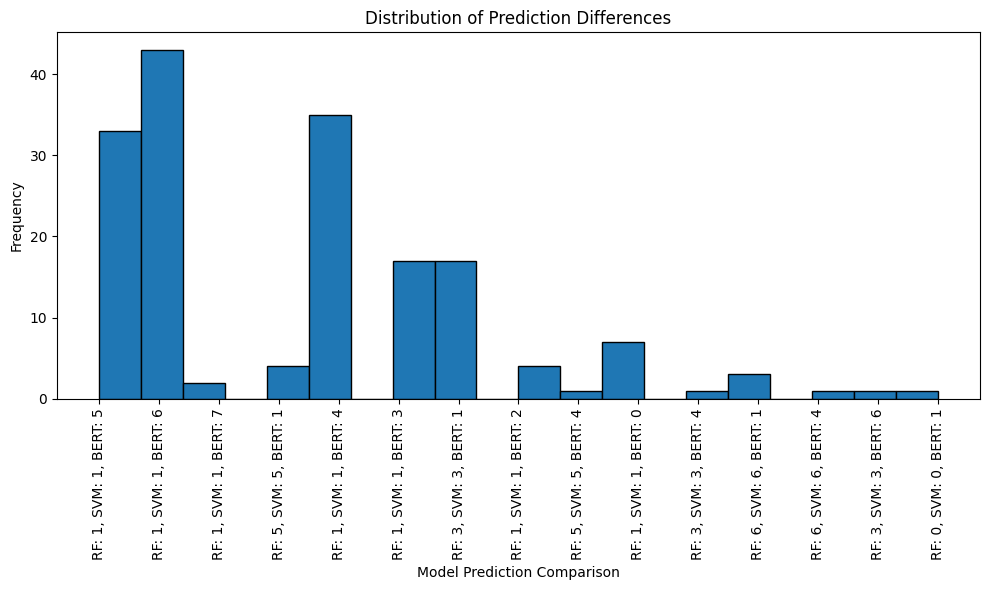

In [ ]:
plt.figure(figsize=(10, 6))
df_pred_final['comparison'] = df_pred_final.apply(
    lambda row: f"RF: {row['randomforest']}, SVM: {row['svm']}, BERT: {row['bert']}", axis=1
)
df_pred_final['difference'] = (df_pred_final['randomforest'] != df_pred_final['svm']) | \
                              (df_pred_final['svm'] != df_pred_final['bert']) | \
                              (df_pred_final['randomforest'] != df_pred_final['bert'])

differences = df_pred_final[df_pred_final['difference']]

plt.hist(differences['comparison'], bins=20, edgecolor='black')
plt.title('Distribution of Prediction Differences')
plt.xlabel('Model Prediction Comparison')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
df_pred_final.to_csv('/content/drive/My Drive/satria_data/pred_final.csv')